XGBOOST FOR 21 days forecast horizon

In [ ]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import chart_studio.plotly as py
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objs as go
import time

from collections import defaultdict
from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

# py.sign_in('<your-user-id>', '<your-api-key>') # sign in to plotly if you haven't done so

#### Input params ##################

# Predicting on day 1470, date 2018-11-01 00:00:00
#pred1 1998
# pred day 2107
#pred_day = 2107               # Predict for this day, for the next H-1 days. Note indexing of days start from 0.
#pred_day = 2247
#pred_day = 2355
pred_day=2498
H = 21                         # Forecast horizon, in days.
#train_size = 2247
#train_size=2003               # Use 8 years of data as train set. Note there are about 252 trading days in a year
train_size=1499                # 5 years data for training
#val_size = 235
#val_size=470                  # Use 2 year of data as validation set
val_size=499                   # use 2 years data after setting training data 5 years
N = 10                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1998


In [ ]:
tic1 = time.time()

# Common functions

In [ ]:
def get_mape(y_true, y_pred):
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [ ]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1

    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))

    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list

    return df_out

def do_scaling(df, N):
    """
    Do scaling for the adj_close and lag cols
    """
    df.loc[:, 'close_scaled'] = (df['close'] - df['close_mean']) / df['close_std']
    for n in range(N,0,-1):
        df.loc[:, 'close_scaled_lag_'+str(n)] = \
            (df['close_lag_'+str(n)] - df['close_mean']) / df['close_std']

        # Remove adj_close_lag column which we don't need anymore
        df.drop(['close_lag_'+str(n)], axis=1, inplace=True)

    return df

def pred_xgboost(model, N, H, prev_vals, prev_mean_val, prev_std_val):
    """
    Do recursive forecasting using xgboost
    Inputs
        model              : the xgboost model
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If predict at time t,
                             prev_vals will contain the N unscaled values at t-1, t-2, ..., t-N
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
    Outputs
        Times series of predictions. Numpy array of shape (H,). This is unscaled.
    """
    forecast = prev_vals.copy()

    for n in range(H):
        forecast_scaled = (forecast[-N:] - prev_mean_val) / prev_std_val

        # Create the features dataframe
        X = defaultdict(list)
        for n in range(N,0,-1):
            X['close_scaled_lag_'+str(n)] = [forecast_scaled[-n]]
        X = pd.DataFrame(X)

        # Do prediction
        est_scaled = model.predict(X)

        # Unscale the prediction
        forecast = np.concatenate([forecast,
                                   np.array((est_scaled * prev_std_val) + prev_mean_val).reshape(1,)])

        # Comp. new mean and std
        prev_mean_val = np.mean(forecast[-N:])
        prev_std_val = np.std(forecast[-N:])

    return forecast[-H:]

def train_pred_eval_model(X_train_scaled,
                          y_train_scaled,
                          y_test,
                          N,
                          H,
                          prev_vals,
                          prev_mean_val,
                          prev_std_val,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If scaled[0] is at time t, prev_vals will contain the N-1 unscaled values at t-1, t-2, ...
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              :
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)

    # Train the model
    model.fit(X_train_scaled, y_train_scaled)

    # Get predicted labels and scale back to original range
    est = pred_xgboost(model, N, H, prev_vals, prev_mean_val, prev_std_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    mae = get_mae(y_test, est)

    return rmse, mape, mae, est, model.feature_importances_

def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_lag_1', 'adj_close_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()

        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df_w_lags, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift

        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift

    return df_w_lags

def get_error_metrics(df,
                      train_size,
                      N,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set,
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              :

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}

    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['close'])

    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'close', N)

    # Do scaling
    df = do_scaling(df, N)

    # Get list of features
    features = []
    for n in range(N,0,-1):
        features.append("close_scaled_lag_"+str(n))

    for i in range(train_size, len(df)-H+1, int(H/2)):
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()

        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)

        # Split into X and y
        X_train_scaled = train[features]
        y_train_scaled = train['close_scaled']
        y_test = test['close']
        prev_vals = train[-N:]['close'].to_numpy()
        prev_mean_val = test.iloc[0]['close_mean']
        prev_std_val = test.iloc[0]['close_std']

        rmse, mape, mae, est, _ = train_pred_eval_model(X_train_scaled,
                                                        y_train_scaled,
                                                        y_test,
                                                        N,
                                                        H,
                                                        prev_vals,
                                                        prev_mean_val,
                                                        prev_std_val,
                                                        seed=seed,
                                                        n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        learning_rate=learning_rate,
                                                        min_child_weight=min_child_weight,
                                                        subsample=subsample,
                                                        colsample_bytree=colsample_bytree,
                                                        colsample_bylevel=colsample_bylevel,
                                                        gamma=gamma)
#         print("N = " + str(N) + ", i = " + str(i) + ", rmse = " + str(rmse) + ", mape = " + str(mape) + ", mae = " + str(mae))

        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est

    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict

def get_error_metrics_one_pred(df,
                               train_size,
                               N,
                               H,
                               seed=100,
                               n_estimators=100,
                               max_depth=3,
                               learning_rate=0.1,
                               min_child_weight=1,
                               subsample=1,
                               colsample_bytree=1,
                               colsample_bylevel=1,
                               gamma=0):
    """
    Given a series consisting of both train+test, do one prediction of forecast horizon H on the test set.
    Inputs
        df                 : train + test dataframe. len(df) = train_size + test_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              :

    Outputs
        rmse, mape, mae, predictions
    """
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['close'])

    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'close', N)

    # Do scaling
    df = do_scaling(df, N)

    # Get list of features
    features = [] # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("close_scaled_lag_"+str(n))

    # Split into train and test
    train = df[:train_size].copy()
    test = df[train_size:train_size+H].copy()

    # Drop the NaNs in train
    train.dropna(axis=0, how='any', inplace=True)

    # Split into X and y
    X_train_scaled = train[features]
    y_train_scaled = train['close_scaled']
    y_test = test['close']
    prev_vals = train[-N:]['close'].to_numpy()
    prev_mean_val = test.iloc[0]['close_mean']
    prev_std_val = test.iloc[0]['close_std']

    rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train_scaled,
                                                                      y_train_scaled,
                                                                      y_test,
                                                                      N,
                                                                      H,
                                                                      prev_vals,
                                                                      prev_mean_val,
                                                                      prev_std_val,
                                                                      seed=seed,
                                                                      n_estimators=n_estimators,
                                                                      max_depth=max_depth,
                                                                      learning_rate=learning_rate,
                                                                      min_child_weight=min_child_weight,
                                                                      subsample=subsample,
                                                                      colsample_bytree=colsample_bytree,
                                                                      colsample_bylevel=colsample_bylevel,
                                                                      gamma=gamma)

    return rmse, mape, mae, est, feature_importances, features

In [ ]:
import joblib

def fit_save_model(df,
                   train_size,
                   N,
                   H,
                   outpath,
                   seed=100,
                   n_estimators=100,
                   max_depth=3,
                   learning_rate=0.1,
                   min_child_weight=1,
                   subsample=1,
                   colsample_bytree=1,
                   colsample_bylevel=1,
                   gamma=0):
    """
    Fit and save model
    Inputs
        df                 : train + test dataframe. len(df) = train_size + test_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        outpath            :
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              :

    Outputs
        rmse, mape, mae, predictions
    """
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['close'])

    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'close', N)

    # Do scaling
    df = do_scaling(df, N)

    # Get list of features
    features = [] # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("close_scaled_lag_"+str(n))

    # Split into train and test
    train = df[:train_size].copy()
    test = df[train_size:train_size+H].copy()

    # Drop the NaNs in train
    train.dropna(axis=0, how='any', inplace=True)

    # Split into X and y
    X_train_scaled = train[features]
    y_train_scaled = train['close_scaled']

    # Generate model
    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)

    # Train the model
    model.fit(X_train_scaled, y_train_scaled)


    joblib.dump(model, outpath)

# Load data

In [ ]:
df = pd.read_csv('/content/RefinryCo.csv', sep = ",")

In [ ]:
df.head()

,date,symbol,name,trading_name,sectoer,open,high,low,close,change,perc_Change,volume_traded,value_traded,no_trades
0,2010-01-02,2030,Saudi Arabia Refineries Co.,SARCO,Energy,49.80,50.25,49.7,49.90,0.10,0.2,76316.0,3809644.65,200.0
1,2010-01-03,2030,Saudi Arabia Refineries Co.,SARCO,Energy,49.90,50.00,49.7,50.00,0.10,0.2,75303.0,3758096.00,151.0
2,2010-01-04,2030,Saudi Arabia Refineries Co.,SARCO,Energy,50.00,50.25,49.7,50.25,0.25,0.5,60310.0,3016818.35,175.0
3,2010-01-05,2030,Saudi Arabia Refineries Co.,SARCO,Energy,50.25,50.75,50.0,50.25,0.00,0.0,135522.0,6834179.00,253.0
4,2010-01-06,2030,Saudi Arabia Refineries Co.,SARCO,Energy,50.25,50.50,50.0,50.00,-0.25,-0.5,93488.0,4689629.50,196.0


In [ ]:
# Remove columns which you can't use as features
#df.drop(['name','open','symbol' ,'high', 'low','volume','trading_name','sectoer','change','perc_Change','volume_traded'], axis=1, inplace=True)

In [ ]:


# Convert Date column to datetime
#df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
#df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,symbol,name,trading_name,sectoer,open,high,low,close,change,perc_Change,volume_traded,value_traded,no_trades,month
0,2010-01-02,2030,Saudi Arabia Refineries Co.,SARCO,Energy,49.80,50.25,49.7,49.90,0.10,0.2,76316.0,3809644.65,200.0,1
1,2010-01-03,2030,Saudi Arabia Refineries Co.,SARCO,Energy,49.90,50.00,49.7,50.00,0.10,0.2,75303.0,3758096.00,151.0,1
2,2010-01-04,2030,Saudi Arabia Refineries Co.,SARCO,Energy,50.00,50.25,49.7,50.25,0.25,0.5,60310.0,3016818.35,175.0,1
3,2010-01-05,2030,Saudi Arabia Refineries Co.,SARCO,Energy,50.25,50.75,50.0,50.25,0.00,0.0,135522.0,6834179.00,253.0,1
4,2010-01-06,2030,Saudi Arabia Refineries Co.,SARCO,Energy,50.25,50.50,50.0,50.00,-0.25,-0.5,93488.0,4689629.50,196.0,1


In [ ]:
for col in df.columns:
    print(col)

date
symbol
name
trading_name 
sectoer
open
high
low
close
change
perc_Change
volume_traded 
value_traded
no_trades 
month


In [ ]:
df.drop(['symbol',	'name'	,'sectoer','open', 'high', 'low','change','perc_Change','value_traded'], axis=1, inplace=True)

In [ ]:
# # Plot with plotly
# data = [go.Scatter(
#             x = df['date'],
#             y = df['adj_close'],
#             mode = 'lines')]

# layout = dict(xaxis = dict(title = 'date'),
#               yaxis = dict(title = 'USD'))

# fig = dict(data=data, layout=layout)
# py.iplot(fig, filename=filename)

# Split into train, validation, test

In [ ]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 2498, date 2020-01-06 00:00:00, with forecast horizon H = 21


In [ ]:
df.iloc[2500]['date']

Timestamp('2020-01-08 00:00:00')

In [ ]:
df.head()

,date,trading_name,close,volume_traded,no_trades,month
0,2010-01-02,SARCO,49.90,76316.0,200.0,1
1,2010-01-03,SARCO,50.00,75303.0,151.0,1
2,2010-01-04,SARCO,50.25,60310.0,175.0,1
3,2010-01-05,SARCO,50.25,135522.0,253.0,1
4,2010-01-06,SARCO,50.00,93488.0,196.0,1


In [ ]:
#df.query('date == 2015-09-21 00:00:00')

In [ ]:
#df.query('date == 2010-01-02')

In [ ]:
train = df[pred_day-train_val_size:pred_day-val_size].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (1499, 6)
val.shape = (499, 6)
train_val.shape = (1998, 6)
test.shape = (21, 6)


# Predict for a specific H (forecast horizon) and a specific date

In [ ]:
# Get error metrics on validation set before hyperparameter tuning
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f%%" % mae_bef_tuning)

RMSE = 2.338
MAPE = 4.842%
MAE = 1.974%


In [ ]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'],
                         y=train['close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'],
                         y=val['close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'],
                         y=test['close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'],
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [ ]:
# Do prediction on test set
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators,
                                                                       max_depth=max_depth,
                                                                       learning_rate=learning_rate,
                                                                       min_child_weight=min_child_weight,
                                                                       subsample=subsample,
                                                                       colsample_bytree=colsample_bytree,
                                                                       colsample_bylevel=colsample_bylevel,
                                                                       gamma=gamma)

print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)
print("MAE = %0.3f" % test_mae_bef_tuning)

RMSE = 3.800
MAPE = 6.724%
MAE = 3.224


In [ ]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'],
                         y=train['close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'],
                         y=val['close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'],
                         y=test['close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'],
                         y=test['close'],
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='price'),
                  xaxis=dict(title='date'))

In [ ]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1])
imp

[('close_scaled_lag_8', 0.028934808),
 ('close_scaled_lag_10', 0.029190099),
 ('close_scaled_lag_4', 0.03318763),
 ('close_scaled_lag_6', 0.0381438),
 ('close_scaled_lag_5', 0.04512662),
 ('close_scaled_lag_7', 0.045478817),
 ('close_scaled_lag_3', 0.04586974),
 ('close_scaled_lag_9', 0.046120908),
 ('close_scaled_lag_2', 0.049334206),
 ('close_scaled_lag_1', 0.6386134)]

# Predict for a specific H (forecast horizon) and a specific date, with hyperparam tuning

In [ ]:
# We use a constant for N here
N_opt = N

## Tuning n_estimators (default=100) and max_depth (default=3)

In [ ]:
param_label = 'n_estimators'
param_list = range(1, 61, 2)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=param,
                                                              max_depth=param2,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate

<ipython-input-246-f12122e5837e>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/30 [00:00<?, ?it/s]

Minutes taken = 24.47


,n_estimators,max_depth,rmse,mape,mae
0,1,2,2.502914,5.402546,2.179111
1,1,3,2.505939,5.411254,2.182362
2,1,4,2.508066,5.416901,2.184637
3,1,5,2.506712,5.411808,2.182582
4,1,6,2.502134,5.398870,2.177602
...,...,...,...,...,...
235,59,5,2.344412,4.884968,1.989483
236,59,6,2.409058,5.009123,2.051186
237,59,7,2.379300,4.982153,2.022189
238,59,8,2.439367,5.088702,2.077422


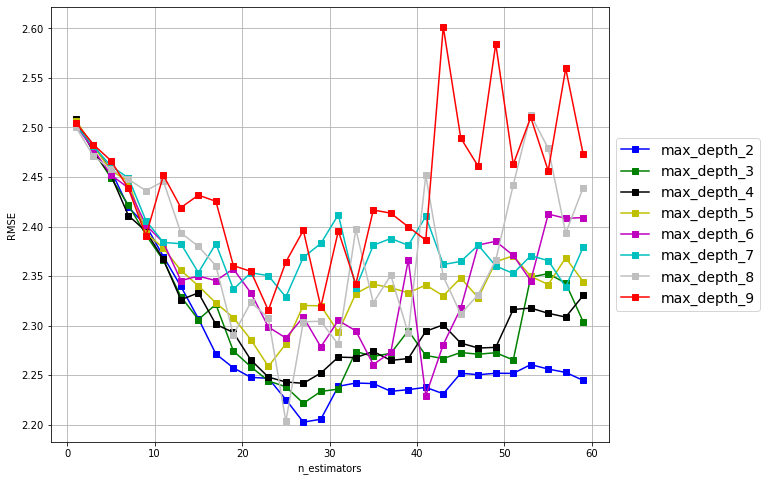

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 2.203
optimum params = 


(27, 2)

In [ ]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 4.565%
optimum params = 


(29, 2)

## Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [ ]:
param_label = 'learning_rate'
param_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate

<ipython-input-250-b0bb9d29de5f>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/8 [00:00<?, ?it/s]

Minutes taken = 6.27


,learning_rate,min_child_weight,rmse,mape,mae
0,0.0001,5,2.518320,5.443772,2.195485
1,0.0001,6,2.518320,5.443772,2.195485
2,0.0001,7,2.518320,5.443772,2.195485
3,0.0001,8,2.518320,5.443772,2.195485
4,0.0001,9,2.518320,5.443772,2.195485
...,...,...,...,...,...
123,0.3000,16,2.296107,4.752719,1.935283
124,0.3000,17,2.298235,4.771856,1.944805
125,0.3000,18,2.269696,4.680197,1.908017
126,0.3000,19,2.278340,4.735389,1.927381


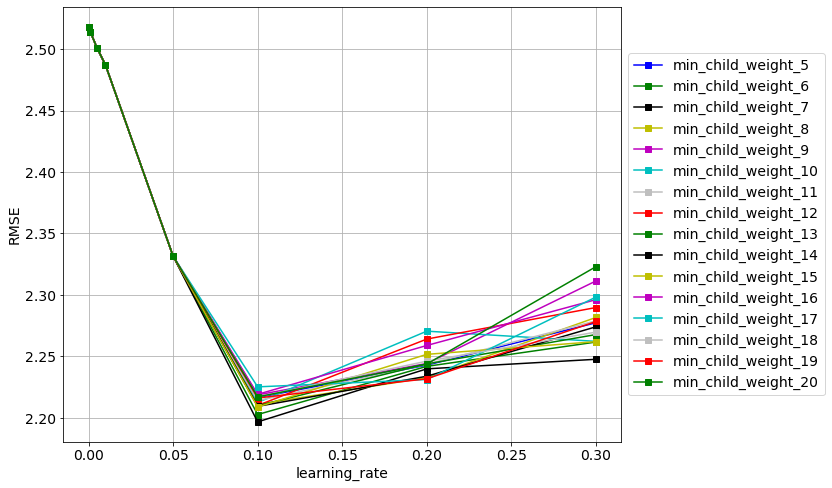

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 2.197
optimum params = 


(0.1, 7)

In [ ]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 4.550%
optimum params = 


(0.1, 7)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [ ]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate

<ipython-input-254-5d97d9276614>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 5.17


,subsample,gamma,rmse,mape,mae
0,0.1,0.0,2.193610,4.527473,1.842834
1,0.1,0.1,2.193610,4.527473,1.842834
2,0.1,0.2,2.193771,4.527896,1.842999
3,0.1,0.3,2.193771,4.527896,1.842999
4,0.1,0.4,2.193771,4.527896,1.842999
...,...,...,...,...,...
105,1.0,0.6,2.196655,4.549558,1.848556
106,1.0,0.7,2.196655,4.549558,1.848556
107,1.0,0.8,2.196655,4.549558,1.848556
108,1.0,0.9,2.196655,4.549558,1.848556


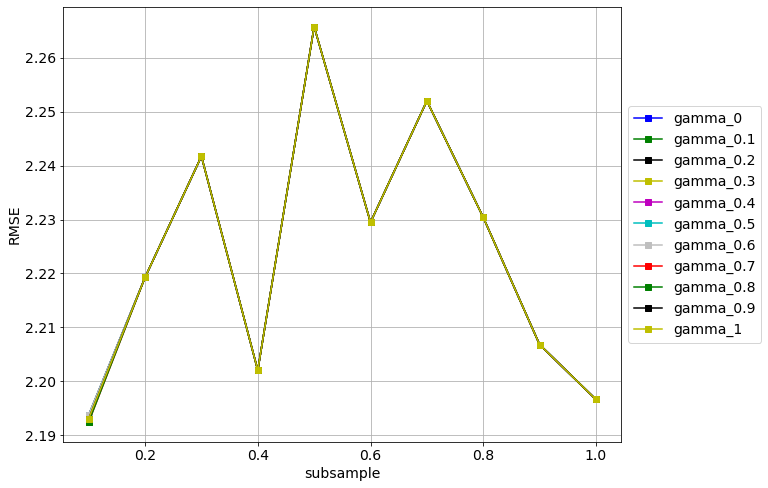

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 2.192
optimum params = 


(0.1, 0.7)

In [ ]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 4.525%
optimum params = 


(0.1, 0.7)

## Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [ ]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)


        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate

<ipython-input-258-ce7109c75a87>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/6 [00:00<?, ?it/s]

Minutes taken = 1.41


,colsample_bytree,colsample_bylevel,rmse,mape,mae
0,0.5,0.5,2.274067,4.735282,1.922723
1,0.5,0.6,2.255397,4.702625,1.912351
2,0.5,0.7,2.255397,4.702625,1.912351
3,0.5,0.8,2.296505,4.776464,1.942379
4,0.5,0.9,2.296505,4.776464,1.942379
5,0.5,1.0,2.261932,4.701485,1.912273
6,0.6,0.5,2.293512,4.769824,1.937699
7,0.6,0.6,2.293512,4.769824,1.937699
8,0.6,0.7,2.293077,4.789771,1.946035
9,0.6,0.8,2.293077,4.789771,1.946035


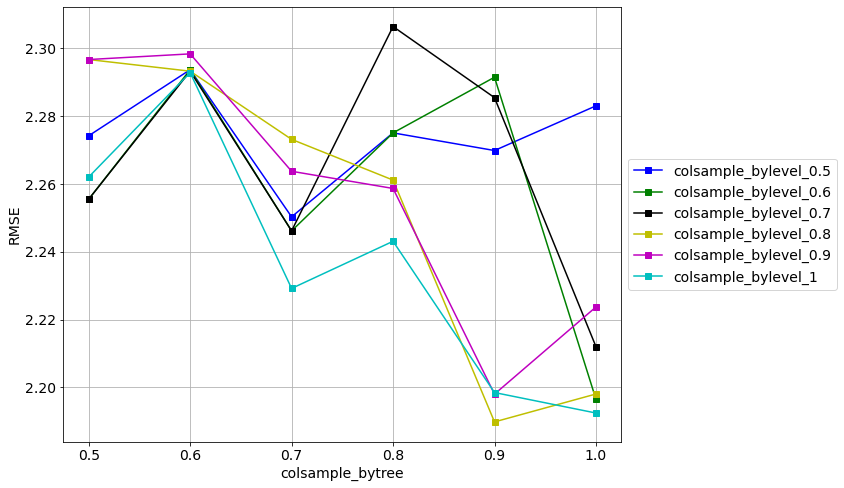

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 2.190
optimum params = 


(0.9, 0.8)

In [ ]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 4.525%
optimum params = 


(1.0, 1.0)

## Final model

In [ ]:
# Get error metrics on validation set after hyperparameter tuning
rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N_opt,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)
print("MAE = %0.3f" % mae_aft_tuning)

RMSE = 2.190
MAPE = 4.537%
MAE = 1.844


In [ ]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'],
                         y=train['close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'],
                         y=val['close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'],
                         y=test['close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'],
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [ ]:
# Do prediction on test set
test_rmse_aft_tuning, test_mape_aft_tuning, test_mae_aft_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N_opt,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators_opt,
                                                                       max_depth=max_depth_opt,
                                                                       learning_rate=learning_rate_opt,
                                                                       min_child_weight=min_child_weight_opt,
                                                                       subsample=subsample_opt,
                                                                       colsample_bytree=colsample_bytree_opt,
                                                                       colsample_bylevel=colsample_bylevel_opt,
                                                                       gamma=gamma_opt)


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)
print("MAE = %0.3f" % test_mae_aft_tuning)

RMSE = 2.759
MAPE = 4.543%
MAE = 2.185


In [ ]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'],
                         y=train['close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'],
                         y=val['close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'],
                         y=test['close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'],
                         y=est,
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='price'),
                  xaxis=dict(title='date'))

In [ ]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1])
imp

[('close_scaled_lag_4', 0.030865593),
 ('close_scaled_lag_10', 0.041821092),
 ('close_scaled_lag_5', 0.05304377),
 ('close_scaled_lag_7', 0.056220733),
 ('close_scaled_lag_9', 0.07473729),
 ('close_scaled_lag_6', 0.078985535),
 ('close_scaled_lag_3', 0.083792105),
 ('close_scaled_lag_8', 0.12904125),
 ('close_scaled_lag_2', 0.18992877),
 ('close_scaled_lag_1', 0.26156387)]

In [ ]:
# Save model
fit_save_model(df[pred_day-train_val_size:pred_day+H],
               train_size+val_size,
               N_opt,
               H,
               "v6c_model.pkl",
               seed=model_seed,
               n_estimators=n_estimators_opt,
               max_depth=max_depth_opt,
               learning_rate=learning_rate_opt,
               min_child_weight=min_child_weight_opt,
               subsample=subsample_opt,
               colsample_bytree=colsample_bytree_opt,
               colsample_bylevel=colsample_bylevel_opt,
               gamma=gamma_opt)

## Tuned params

In [ ]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,before_tuning,after_tuning
0,n_estimators,100.000,27.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.100
3,min_child_weight,1.000,7.000
4,subsample,1.000,0.100
5,colsample_bytree,1.000,0.900
6,colsample_bylevel,1.000,0.800
7,gamma,0.000,0.700
8,val_rmse,2.338,2.190
9,val_mape,4.842,4.537


In [ ]:
toc1 = time.time()
print("Total minutes taken = {0:.2f}".format((toc1-tic1)/60.0))

Total minutes taken = 37.62


# Findings

In [ ]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'].strftime("%Y-%m-%d"), H))

Predicting on day 2498, date 2020-01-06, with forecast horizon H = 21


In [ ]:
rmse_bef_tuning, rmse_aft_tuning

(2.3378639295057164, 2.1898703040938208)

In [ ]:
test_rmse_bef_tuning, test_rmse_aft_tuning

(3.8002111753311394, 2.759368368025484)

In [ ]:
# Put results into pickle
#/
pickle.dump(rmse_bef_tuning, open("v6c_val_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(rmse_aft_tuning, open("v6c_val_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_bef_tuning, open("v6c_test_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_bef_tuning, open("v6c_test_mape_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_bef_tuning, open("v6c_test_mae_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_aft_tuning, open("v6c_test_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_aft_tuning, open("v6c_test_mape_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_aft_tuning, open("v6c_test_mae_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(est, open("v6c_test_est_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [ ]:
# Consolidate results
# H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
# train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
# val_size = 252                 # Use 1 year of data as validation set
# N = 10                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
results = defaultdict(list)
tests = {} # the predictions
date_list = ['2018-01-03',
             '2018-06-05',
             '2019-01-03',
             '2019-06-11',
             '2020-01-06'
             ]
for date in date_list:
    results['date'].append(date)
    results['val_rmse_bef_tuning'].append(pickle.load(open( "/content/v6c_val_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['val_rmse_aft_tuning'].append(pickle.load(open( "/content/v6c_val_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_bef_tuning'].append(pickle.load(open( "/content/v6c_test_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_aft_tuning'].append(pickle.load(open( "/content/v6c_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mape_bef_tuning'].append(pickle.load(open( "/content/v6c_test_mape_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mape_aft_tuning'].append(pickle.load(open( "/content/v6c_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mae_bef_tuning'].append(pickle.load(open( "/content/v6c_test_mae_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mae_aft_tuning'].append(pickle.load(open( "/content/v6c_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    tests[date] = pickle.load(open( "/content/v6c_test_est_aft_tuning_" + date + ".pickle", "rb"))

results = pd.DataFrame(results)
results

,date,val_rmse_bef_tuning,val_rmse_aft_tuning,test_rmse_bef_tuning,test_rmse_aft_tuning,test_mape_bef_tuning,test_mape_aft_tuning,test_mae_bef_tuning,test_mae_aft_tuning
0,2018-01-03,2.203311,2.095049,0.897610,0.711831,2.494869,1.881303,0.793695,0.599369
1,2018-06-05,2.273652,2.155323,3.136853,3.248276,6.076296,6.346111,2.779177,2.900825
2,2019-01-03,1.985822,1.848065,1.152986,1.192717,2.322931,2.424868,1.010431,1.054464
3,2019-06-11,2.025718,1.882491,0.713259,1.133818,1.536693,2.484333,0.578483,0.938274
4,2020-01-06,2.337864,2.189870,3.800211,2.759368,6.723877,4.542854,3.223708,2.185125


In [ ]:
results.mean()

<ipython-input-298-14741f1863b3>:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



val_rmse_bef_tuning     2.165273
val_rmse_aft_tuning     2.034160
test_rmse_bef_tuning    1.940184
test_rmse_aft_tuning    1.809202
test_mape_bef_tuning    3.830933
test_mape_aft_tuning    3.535894
test_mae_bef_tuning     1.677099
test_mae_aft_tuning     1.535611
dtype: float64

In [ ]:
#Plot all predictions
fig = go.Figure()

# Add traces
data = [go.Scatter(
            x = df['date'],
            y = df['close'],
            mode = 'lines')]

fig.add_trace(go.Scatter(x=df['date'],
                         y=df['close'],
                         mode='lines',
                         line=dict(color='blue')))

# Plot the predictions
n = 0
for key in tests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['date'],
                             y=tests[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='Close Price XGBoost'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2018-01-013', '2020-01-06'])
fig.update_yaxes(range=[20, 90])

NameError: ignored